In [65]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from CHEM274.LinReg import PolyReg
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\CHEM274\\Cdl-fitting'

In [66]:
# Import Data
exp100 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.1Vs-1_P-07-21")
exp150 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.15Vs-1_P-07-22")
exp200 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.2Vs-1_P-07-23")
exp250 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.25Vs-1_P-07-24")
exp300 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.3Vs-1_P-07-25")
exp400 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.4Vs-1_P-07-26")

exp_series = [exp100, exp150, exp200, exp250, exp300, exp400]

In [75]:
exp200.data

,E_program,Ecell,iw,t,forward,savgol_iw
0,0.000000,-0.101060,-6.278674e-08,0.000000,None,-1.376509e-07
1,0.000000,-0.101718,-6.278674e-08,0.000278,None,-1.371346e-07
2,0.000000,-0.101718,-6.278674e-08,0.000556,None,-1.366215e-07
3,0.000000,-0.101389,-6.278674e-08,0.000833,None,-1.361115e-07
4,0.000000,-0.101389,-3.916420e-07,0.001111,None,-1.356046e-07
...,...,...,...,...,...,...
14395,0.000222,-0.101389,-7.204973e-07,3.998611,False,-5.246288e-07
14396,0.000167,-0.100731,-1.049353e-06,3.998889,False,-5.224128e-07
14397,0.000111,-0.101060,-3.916420e-07,3.999167,False,-5.201812e-07
14398,0.000056,-0.101060,-7.204973e-07,3.999444,False,-5.179340e-07


In [67]:
for exp in exp_series:
    # All Cdl measurements were taken week 4, so apply reference calibration. E_program is left unchanged.
    exp.data['Ecell'] = exp.data['Ecell'] - 0.101984

    # Figure out what the real h_time was. This is different from the programmed h_time due to automatic sample number rounding during acquisition.
    h_pot = exp.data.loc[0, 'E_program']
    h_time = exp.data.loc[exp.data['E_program'] > h_pot]['t'].min()
    # Put it in params
    h_time_row = pd.Series(['h_time', h_time], index=['parameter', 'value'])
    exp.params = exp.params.append(h_time_row, ignore_index=True)

    # Separate forward and reverse scans.
    scan_direction_bools = []
    # for i in range(len(exp.data['E_program'])):
    # # This checks every data point individually, so it's a bit slow
    #     if exp.data.loc[i, 't'].item() < exp.params.loc[exp.params['parameter']=='h_time', 'value'].item():
    #         scan_direction_bools.append(None)
    #     elif i == 0:
    #         scan_direction_bools.append(True)
    #     elif exp.data['E_program'][i - 1]  < exp.data['E_program'][i]:
    #         scan_direction_bools.append(True)
    #     else:
    #         scan_direction_bools.append(False)

    '''
    It seems that there is so much noise in Ecell and such a delay between E_program and Ecell that the only way to separate forward and reverse scans is by time.
    '''
    Ecell_lead_time = .200 # Manually set delay parameter in seconds
    switching_time = (h_time + exp.data['t'].max()) / 2 - Ecell_lead_time
    for i in range(len(exp.data['E_program'])):
        # This checks every data point individually, so it's a bit slow
        if exp.data.loc[i, 't'].item() < h_time:
            scan_direction_bools.append(None)
        elif exp.data.loc[i, 't'].item() < switching_time:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)

    exp.data['forward'] = scan_direction_bools

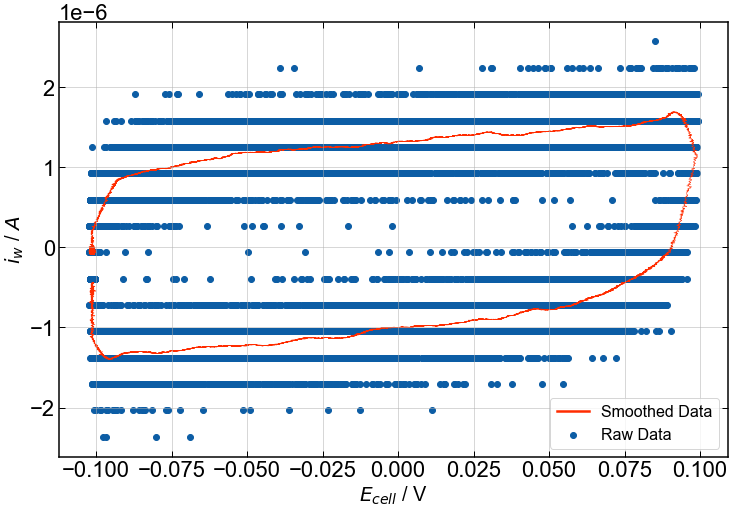

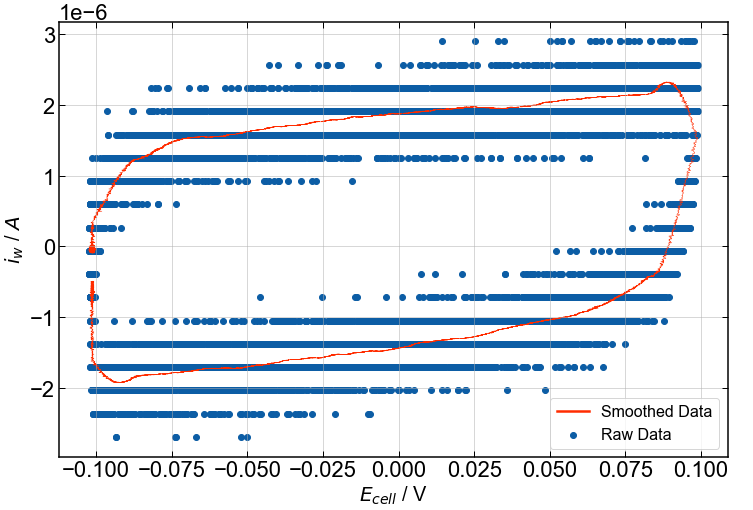

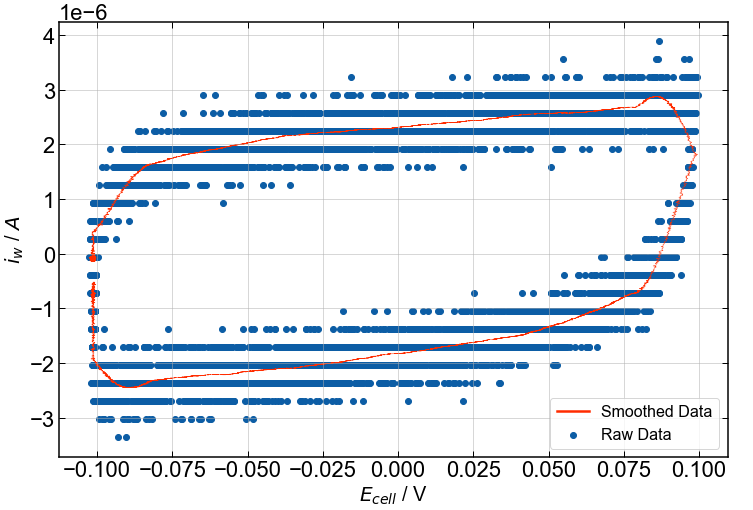

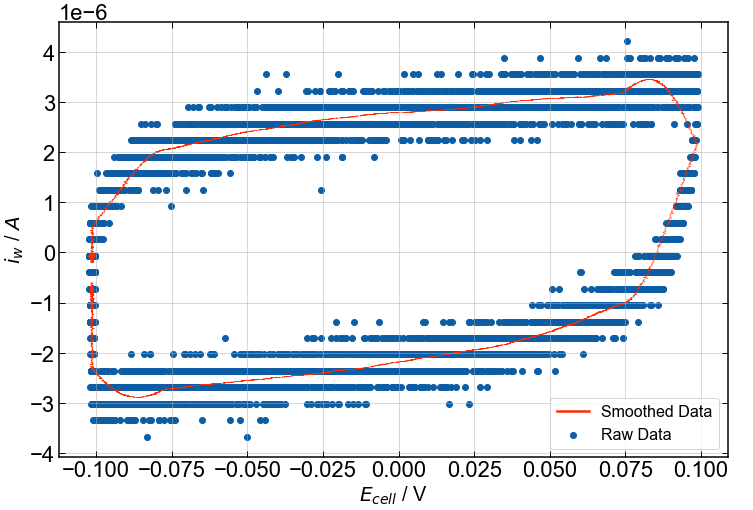

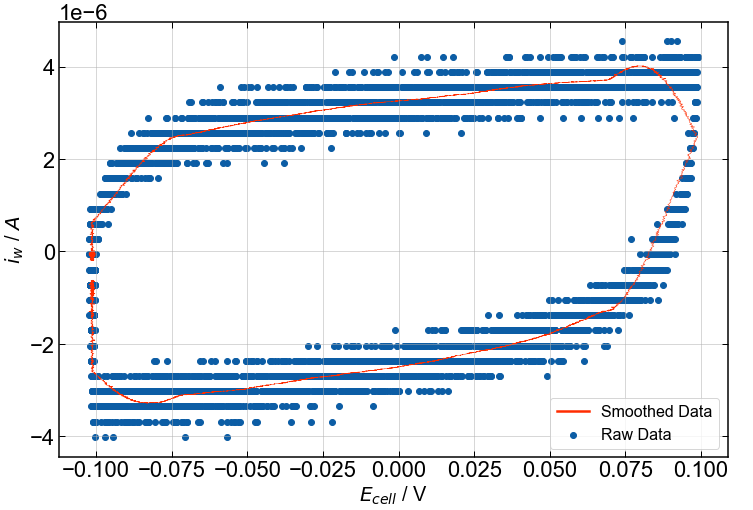

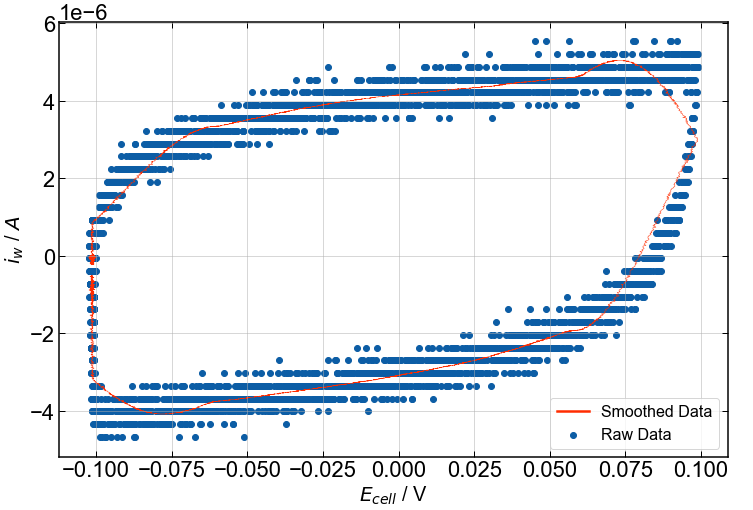

In [68]:
ic_list = []
raw_axes = []
coplot_axes = []
for exp in exp_series:
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 725, 3)

    # Average a few points together near the end
    left_bound, right_bound = .050, 0.055
    filter = exp.data[exp.data['forward'] == True]['Ecell'].between(left_bound, right_bound)
    ic = exp.data.loc[exp.data[exp.data['forward'] == True].index.where(filter).dropna()]['savgol_iw'].mean()
    ic_list.append(ic)

    # Check the fits
    fig = plt.figure()
    ax = fig.add_subplot()

    # ax.scatter(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s')
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], color='C1', label='Smoothed Data', lw=.5, zorder=.5)
    ax.scatter(exp.data['Ecell'], exp.data['iw'], label = 'Raw Data', zorder=0)
    # ax.scatter((left_bound+right_bound)/2, ic, c='C03', marker='_', s=500, zorder=1)
    ax.set_xlabel('$E_{cell}$ / V')
    ax.set_ylabel('$i_{w}$ / $A$')

    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    leg = fig.legend(loc=(0.73, 0.12))
    for line in leg.get_lines():
        line.set_linewidth(2.5)
    raw_axes.append(ax)
    # fig.savefig(r'C:\Users\jgage\Desktop\temp\v='+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' Vs-1.svg')

coplot_axes.append(raw_axes[2])

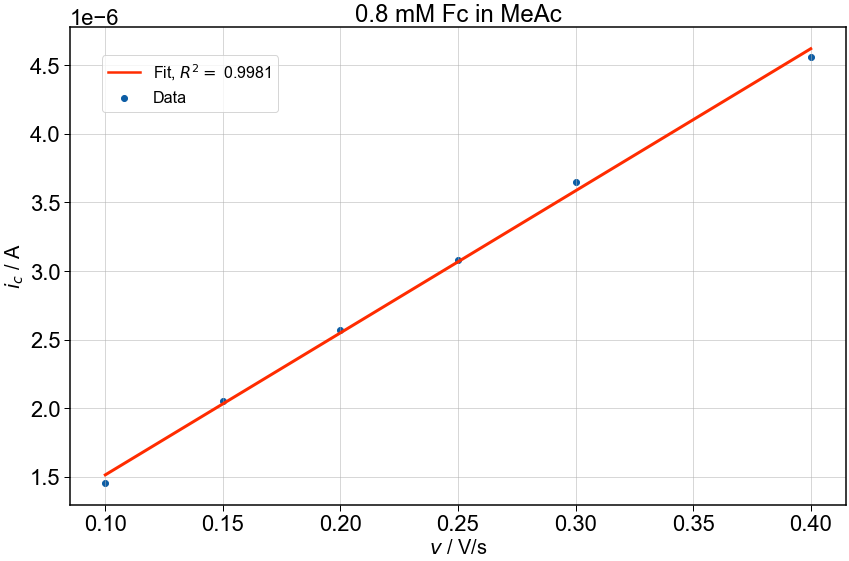

coef_deg1       1.034872e-05
std_err_deg1    2.251673e-07
coef_deg0       4.798478e-07
std_err_deg0    5.703744e-08
r_squared       9.981099e-01
s_y             5.438307e-08
dtype: float64

In [73]:
scan_rates = []

for exp in exp_series:
    scan_rates.append(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item())

x, y = scan_rates, ic_list

fit = PolyReg(x, y, 1)

fig, ax = plt.subplots()

ax.scatter(x, y, label='Data')
ax.plot(x, fit.eval(x), label='Fit, $R^2 =$ '+ '{:.4f}'.format(fit.r_squared), color='C01')


ax.set_xlabel('$v$ / V/s')
ax.set_ylabel('$i_{c}$ / A')
ax.set_title('0.8 mM Fc in MeAc')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.tight_layout()
leg = fig.legend(loc=(0.12, 0.8))
for line in leg.get_lines():
    line.set_linewidth(2.5)
plt.show()
# fig.savefig(r'C:\Users\jgage\Desktop\temp\Fc-MeAc-Cdl-line.svg')
fit.report()

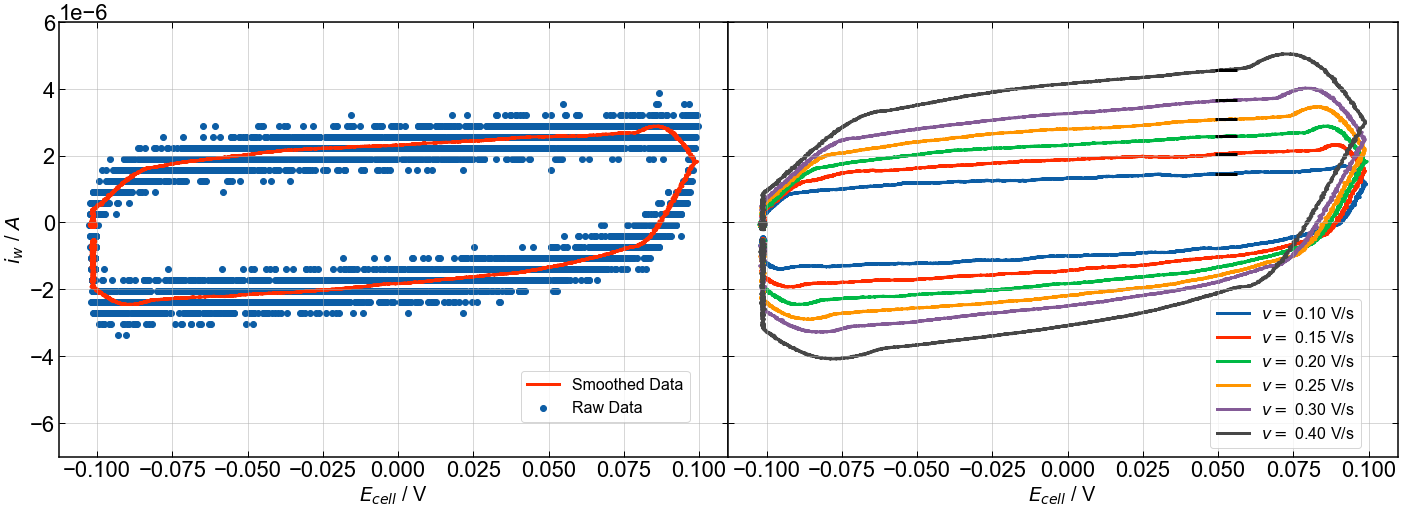

In [70]:
ic_list = []

fig, (ax2, ax) = plt.subplots(1, 2, figsize=(24,8), sharey=True)
for exp in exp_series:
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 725, 3)

    # Average a few points together near the end
    left_bound, right_bound = .050, 0.055
    filter = exp.data[exp.data['forward'] == True]['Ecell'].between(left_bound, right_bound)
    ic = exp.data.loc[exp.data[exp.data['forward'] == True].index.where(filter).dropna()]['savgol_iw'].mean()
    ic_list.append(ic)


    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], label = '$v=$ '+'{:.2f}'.format(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s', zorder=0)
    ax.scatter((left_bound+right_bound)/2, ic, c='k', marker='_', s=500, zorder=1)

# Add 200 mV/s data on the side
ax2.plot(exp200.data['Ecell'], exp200.data['savgol_iw'], color='C1', label='Smoothed Data', lw=3, zorder=.5)
ax2.scatter(exp200.data['Ecell'], exp200.data['iw'], label = 'Raw Data', zorder=0)


ax.set_xlabel('$E_{cell}$ / V')
ax2.set_xlabel('$E_{cell}$ / V')
ax2.set_ylabel('$i_{w}$ / $A$')

ax2.set_ylim(-7.0e-6, 6.0e-6)
ax.set_ylim(-7.0e-6, 6.0e-6)


ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax2.tick_params(axis='both', which='both', direction='in', right=True, top=True)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
leg1 = ax.legend(loc=(0.72, 0.02))
for line in leg.get_lines():
    line.set_linewidth(2.5)

leg2 = ax2.legend(loc=(0.69, 0.08))
for line in leg.get_lines():
    line.set_linewidth(2.5)

fig.subplots_adjust(wspace=0, hspace=0)

In [71]:
# fig.savefig(r'C:\Users\jgage\Desktop\temp\Cdl-series-coplot.svg')